<a href="https://colab.research.google.com/github/rstrauss127/ASR/blob/main/AI_689_HW4_Rebecca_Strauss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Spike Time Dependent Plascticity
## Setup

In [15]:
# IMPORTS AND PARAMETERS

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Simulation parameters
T = 2000   # Total duration of simulation is 2000 ms.
dt = 1.0 # Simulation advances in 1 ms steps.
time = np.arange(0, T, dt) # array of all time points in the simulation.


# LIF neuron parameters
tau_m = 20    # Membrane time constant
V_th = 0.5    # Firing threshold
V_reset = 0.0 # Voltage reset after spike
R = 1.0       # Membrane resistance

# STDP parameters
A_plus = 0.01 # controls weight changes for LTP/LTD.
A_minus = 0.012 # controls weight changes for LTP/LTD.
tau_trace = 20.0 # decay constant for pre/post spike traces.


reward_magnitudes = [0.0, 0.2, 0.5, 1.0]  # Range of rewards for comparison

n_inputs = 10 # Network with 10 input neurons.
results = {} # stores simulation outputs for each reward level.

## Simulation Details: reward-modulated spike-timing-dependent plasticity (STDP) model with a single leaky integrate-and-fire (LIF) neuron receiving input from 2 spike-generating input neurons,

In [16]:
# Repeat the simulation for each reward setting.
for reward_magnitude in reward_magnitudes:
    # Initialize weights
    weights = np.random.uniform(0.5, 0.9, size=(n_inputs, 1)) # Random initial synaptic weights.

    # Spike traces and spike time logs initialized.
    pre_traces = np.zeros(n_inputs)
    post_trace = 0.0
    pre_spike_times = [[] for _ in range(n_inputs)]
    post_spike_times = []
    input_spikes = np.random.rand(n_inputs, len(time)) < 50 * dt / 1000

    # Reset membrane potential
    V = V_reset
    V_trace = []
    weights_trace = [weights.copy()]
    reward_trace = []

    # Iterate through each timestep
    for t_idx, t in enumerate(time):
        # Exponential decay of spike traces.
        pre_traces *= np.exp(-dt / tau_trace)
        post_trace *= np.exp(-dt / tau_trace)

        # Compute Membrane Potential
        I = np.sum(weights[:, 0] * input_spikes[:, t_idx]) # Input current is weighted sum of spikes.
        dV = (-V + R * I) / tau_m * dt # Membrane potential updated using LIF dynamics
        V += dV
        V_trace.append(V)

        # Post-Synaptic Spike Check
        reward = 0
        if V >= V_th: # If threshold is crossed, neuron fires.
            V = V_reset
            post_spike_times.append(t)
            post_trace += 1
            reward = reward_magnitude # Reward is applied

        # Pre-Synaptic Spike Detection
        for i in range(n_inputs):
            if input_spikes[i, t_idx]: # If a pre-synaptic neuron spikes, increment its trace.
                pre_traces[i] += 1
                pre_spike_times[i].append(t)

        # STDP Weight Update Rule
        for i in range(n_inputs):
            # Synaptic weight is updated using pre and post spike traces.
            dw = A_plus * pre_traces[i] * post_trace - A_minus * post_trace * pre_traces[i]
            # Reward modulates the magnitude of the weight update
            dw *= (1 + reward)
            weights[i, 0] += dw

        # Normalize and log weights and rewards
        weights = np.clip(weights, 0.0, 1.0)
        weights_trace.append(weights.copy())
        reward_trace.append(reward)

    # Store outputs
    results[reward_magnitude] = {
        "V_trace": V_trace,
        "weights_trace": np.array(weights_trace),
        "reward_trace": reward_trace,
        "input_spikes": input_spikes
    }


Visualize

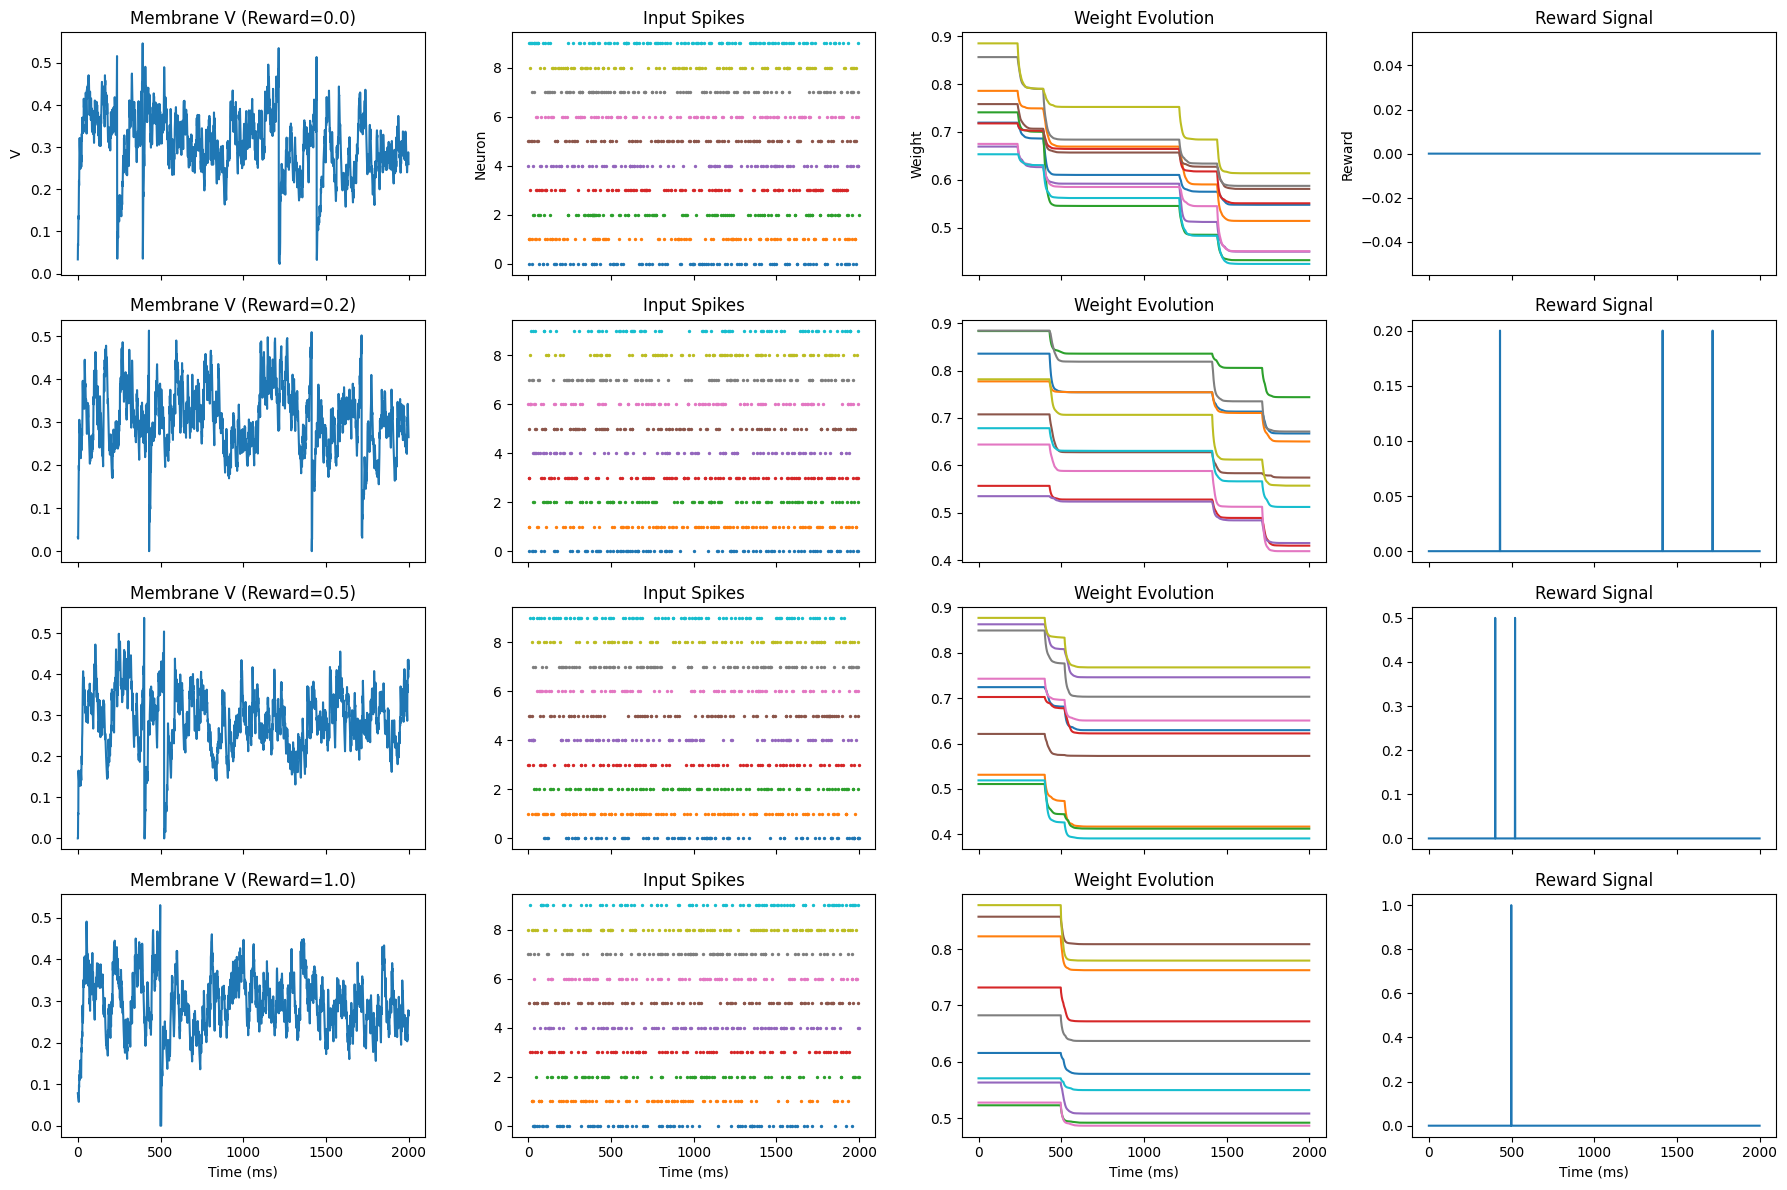

In [18]:
# Plotting
fig, axes = plt.subplots(len(reward_magnitudes), 4, figsize=(18, 12), sharex=True)

# Loop through saved results per reward level
for idx, reward_magnitude in enumerate(reward_magnitudes):
    res = results[reward_magnitude]
    time_range = time

    # Plot V_trace
    axes[idx][0].plot(time_range, res["V_trace"])
    axes[idx][0].set_title(f"Membrane V (Reward={reward_magnitude})")

    # Plot Raster of Spikes
    for i in range(n_inputs):
        spike_times = time[res["input_spikes"][i]]
        axes[idx][1].scatter(spike_times, [i]*len(spike_times), s=2)
    axes[idx][1].set_title("Input Spikes")

    # Plot Synaptic Weights
    for i in range(n_inputs):
        axes[idx][2].plot(time_range, res["weights_trace"][1:, i, 0], label=f"w{i}")
    axes[idx][2].set_title("Weight Evolution")

    # Plot Reward Signal
    axes[idx][3].plot(time_range, res["reward_trace"])
    axes[idx][3].set_title("Reward Signal")

for ax in axes[-1]:
    ax.set_xlabel("Time (ms)")

axes[0][0].set_ylabel("V")
axes[0][1].set_ylabel("Neuron")
axes[0][2].set_ylabel("Weight")
axes[0][3].set_ylabel("Reward")

plt.tight_layout()
plt.show()


## Each subplot shows:

* Membrane V:	Output neuron's voltage trace—spikes when it crosses 0.5
* Input Spikes (Raster):	Random Poisson-like spikes from 2 input neurons
* Weight Evolution:	Time evolution of synaptic weights under STDP + reward
* Reward-modulated Current:	Total synaptic input current driving the neuron



## In conclusion:
What's being simulated?
1. Neuron Dynamics
A single LIF neuron integrates inputs over time and spikes when its membrane voltage exceeds a threshold.

2. Synaptic Plasticity (STDP)
Each input neuron is connected to the output neuron via plastic synapses.

Synaptic weights are updated via STDP, influenced by:

  * The timing of pre/post spikes (causal vs. anti-causal)

  * A reward signal that scales the weight change magnitude

3. Reward Modulation
You're testing 4 different reward_magnitude levels: [0.0, 0.2, 0.5, 1.0].

* Goal: observe how reward enhances learning by amplifying LTP (Long-Term Potentiation).

